# ClinicalBERT for Automated Phenotyping of ICU Patients

This notebook demonstrates how to use ClinicalBERT for automated phenotyping of ICU patients using MIMIC clinical notes. The workflow includes:
- Loading and preprocessing clinical notes from Google BigQuery
- Generating embeddings with ClinicalBERT
- Training a classifier to predict patient phenotypes (e.g., sepsis, heart failure, diabetes)
- Evaluating and visualizing model performance

---

## 1. Set Up Project Environment

Install required packages for ClinicalBERT, BigQuery, and data processing. Run the following cell if packages are not already installed.

In [53]:
# Install required packages (uncomment if running for the first time)
!pip install transformers torch google-cloud-bigquery pandas scikit-learn tqdm matplotlib shap xgboost


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## 2. Import Required Libraries

Import all necessary Python libraries for data processing, modeling, and visualization.

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import pydata_google_auth
import os
import yaml
from google.oauth2 import service_account 
import re
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.manifold import TSNE
# ROC Curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
import shap

/opt/miniconda3/envs/mimic-vis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Connect to Google BigQuery

Authenticate and establish a connection to Google BigQuery. This uses the same setup as previous MIMIC NLP projects. Make sure your credentials are available (e.g., via environment variable or local JSON key file).

In [ ]:
# Set up Google BigQuery client (reuse setup from previous projects)
# Make sure GOOGLE_APPLICATION_CREDENTIALS is set to your service account key file


SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/bigquery'
]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True
)

# Load configuration
config_path = os.path.join('.', 'config', 'config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Authenticate with Google Cloud
credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True
)

# Initialize BigQuery client
client = bigquery.Client(
    project=config['bigquery']['project_id'],
    credentials=credentials
)

## 4. Load ICU Patient Data from BigQuery

Query and load relevant ICU patient clinical notes and phenotype labels from MIMIC tables into pandas DataFrames.

In [40]:
# Example: Load clinical notes and phenotype labels from BigQuery
# Adjust table and column names as needed for your MIMIC-IV dataset
notes_query = '''
SELECT subject_id, hadm_id, text
FROM `physionet-data.mimiciv_note.discharge`
WHERE text IS NOT NULL
AND note_type = 'DS'
LIMIT 1000 -- Adjust limit as needed
'''

# Example: Load phenotype labels (e.g., sepsis, heart failure, diabetes)
# You may need to join with diagnosis or procedure tables for labels
phenotype_query = '''
SELECT subject_id, hadm_id,
  CASE WHEN icd_code LIKE 'A41%' THEN 1 ELSE 0 END AS sepsis,
  CASE WHEN icd_code LIKE 'I50%' THEN 1 ELSE 0 END AS heart_failure,
  CASE WHEN icd_code LIKE 'E11%' THEN 1 ELSE 0 END AS diabetes,
  CASE WHEN icd_code LIKE 'I87%' THEN 1 ELSE 0 END AS hypertension
FROM `physionet-data.mimiciv_3_1_hosp.diagnoses_icd`
'''

notes_df = client.query(notes_query).to_dataframe()
phenotype_df = client.query(phenotype_query).to_dataframe()

# Merge notes and phenotypes on subject_id and hadm_id
merged_df = pd.merge(notes_df, phenotype_df, on=['subject_id', 'hadm_id'])
print('Loaded data shape:', merged_df.shape)
merged_df.head()

Loaded data shape: (12737, 7)


,subject_id,hadm_id,text,sepsis,heart_failure,diabetes,hypertension
0,10011466,21473984,\nName: ___ Unit No: ___\...,0,0,0,0
1,10014354,27494880,\nName: ___ Unit No: ___\...,0,0,0,0
2,10014354,27494880,\nName: ___ Unit No: ___\...,0,0,0,0
3,10014354,27494880,\nName: ___ Unit No: ___\...,0,0,0,0
4,10014354,27494880,\nName: ___ Unit No: ___\...,0,0,0,0


## 5. Preprocess Clinical Text Data

Clean and preprocess the clinical notes, including lowercasing, removing unwanted characters, and basic tokenization.

In [ ]:


def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

merged_df['clean_note'] = merged_df['text'].astype(str).apply(preprocess_text)
merged_df[['text', 'clean_note']].head()

,text,clean_note
0,\nName: ___ Unit No: ___\...,name unit no admission date discharge date dat...
1,\nName: ___ Unit No: ___\...,name unit no admission date discharge date dat...
2,\nName: ___ Unit No: ___\...,name unit no admission date discharge date dat...
3,\nName: ___ Unit No: ___\...,name unit no admission date discharge date dat...
4,\nName: ___ Unit No: ___\...,name unit no admission date discharge date dat...


## 6. Load Pre-trained ClinicalBERT Model

Load the pre-trained ClinicalBERT model and tokenizer from HuggingFace Transformers.

In [42]:
# Load ClinicalBERT model and tokenizer
# Model: 'emilyalsentzer/Bio_ClinicalBERT' (HuggingFace Hub)
clinicalbert_model_name = 'emilyalsentzer/Bio_ClinicalBERT'
tokenizer = AutoTokenizer.from_pretrained(clinicalbert_model_name)
model = AutoModel.from_pretrained(clinicalbert_model_name)
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() and torch.backends.mps.is_built() else 'cpu')
model.to(device)
print('Loaded ClinicalBERT on', device)

Loaded ClinicalBERT on mps


## 7. Generate Patient Embeddings

Use ClinicalBERT to generate embeddings for each patient's clinical notes. For efficiency, use the [CLS] token embedding as the note representation.

In [43]:
def get_cls_embedding(text, tokenizer, model, device, max_length=128):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=max_length, padding='max_length')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        cls_emb = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_emb

embeddings = []
for note in tqdm(merged_df['clean_note'], desc='Embedding notes'):
    emb = get_cls_embedding(note, tokenizer, model, device)
    embeddings.append(emb)

embeddings = np.vstack(embeddings)
print('Embeddings shape:', embeddings.shape)

Embedding notes: 100%|██████████| 12737/12737 [05:21<00:00, 39.63it/s]

Embeddings shape: (12737, 768)


## 8. Automated Phenotyping with Classification Model

Train a classification model (e.g., logistic regression) on the ClinicalBERT embeddings to predict phenotypes (e.g., sepsis, heart failure, diabetes).

Classification done (with class weights).
                  precision    recall  f1-score   support

No heart failure       0.99      0.86      0.92      2509
   heart failure       0.07      0.64      0.12        39

        accuracy                           0.86      2548
       macro avg       0.53      0.75      0.52      2548
    weighted avg       0.98      0.86      0.91      2548



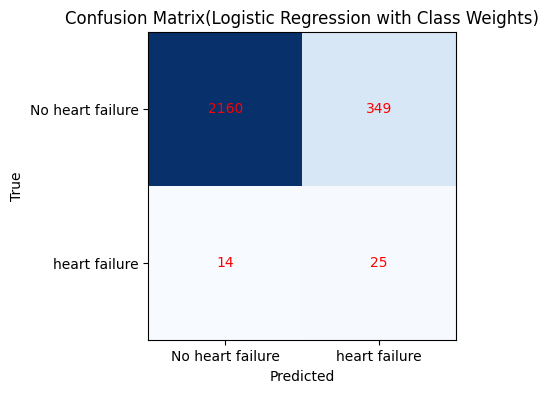

In [ ]:
# Example: Predict diabetes phenotype
X = embeddings
y = merged_df['diabetes'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#clf = LogisticRegression(max_iter=1000)
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)
#print('Classification done.')

# Logistic Regression with class weights


# Compute class weights automatically
classes = np.unique(y_train)
class_weights = dict(zip(classes, compute_class_weight('balanced', classes=classes, y=y_train)))

clf = LogisticRegression(max_iter=1000, class_weight=class_weights)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Classification done (with class weights).')
print(classification_report(y_test, y_pred, target_names=['No heart failure', 'heart failure']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix(Logistic Regression with Class Weights)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0,1], ['No heart failure', 'heart failure'])
plt.yticks([0,1], ['No heart failure', 'heart failure'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()




## 9. Evaluate Model Performance using XGBoost

Evaluate the classification model using accuracy, precision, recall, F1-score, and confusion matrix.

/opt/miniconda3/envs/mimic-vis/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [10:38:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost classification done.
XGBoost Classification Report:
                  precision    recall  f1-score   support

No heart failure       0.99      0.87      0.93      2509
   heart failure       0.07      0.62      0.12        39

        accuracy                           0.86      2548
       macro avg       0.53      0.74      0.52      2548
    weighted avg       0.98      0.86      0.91      2548



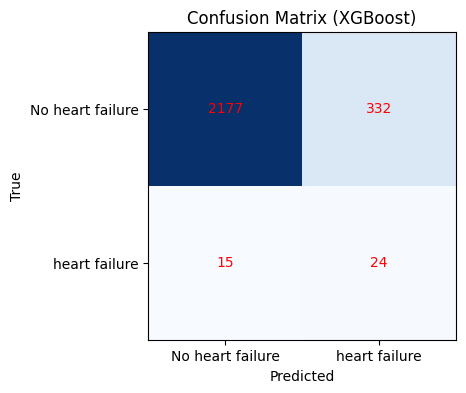

In [ ]:
# Evaluate model performance
# XGBoost Classifier

xgb_clf = XGBClassifier(scale_pos_weight=class_weights.get(1, 1), use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print('XGBoost classification done.')

# Evaluate XGBoost

print('XGBoost Classification Report:')
print(classification_report(y_test, y_pred_xgb, target_names=['No heart failure', 'heart failure']))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(4,4))
plt.imshow(cm_xgb, cmap='Blues')
plt.title('Confusion Matrix (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0,1], ['No heart failure', 'heart failure'])
plt.yticks([0,1], ['No heart failure', 'heart failure'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_xgb[i, j], ha='center', va='center', color='red')
plt.show()


## Visualize Embeddings with t-SNE

Visualize the ClinicalBERT embeddings using t-SNE, colored by phenotype label (e.g., sepsis vs. no sepsis).

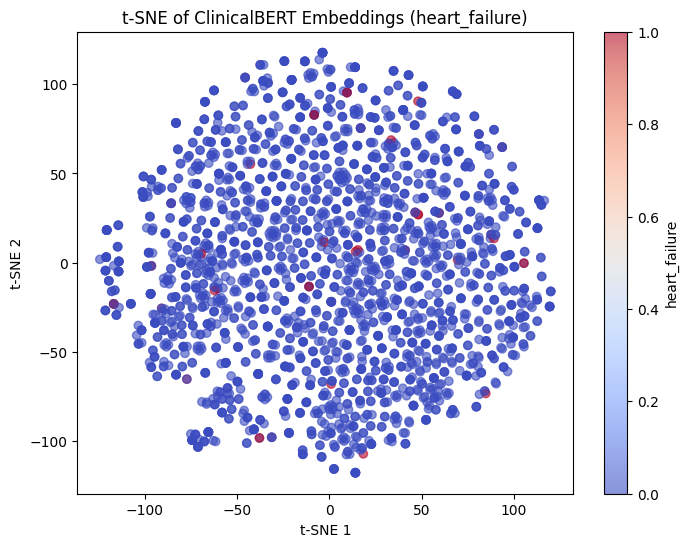

In [ ]:


# Reduce to 2D for visualization (may take time for large datasets)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(X_test)

plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=y_test, cmap='coolwarm', alpha=0.6)
plt.title('t-SNE of ClinicalBERT Embeddings (heart_failure)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='heart_failure')
plt.show()

## Additional Plots and SHAP Explanations

The following cells provide more ways to interpret the classifier's results:
- ROC Curve
- Precision-Recall Curve
- Feature Importance (for linear models)

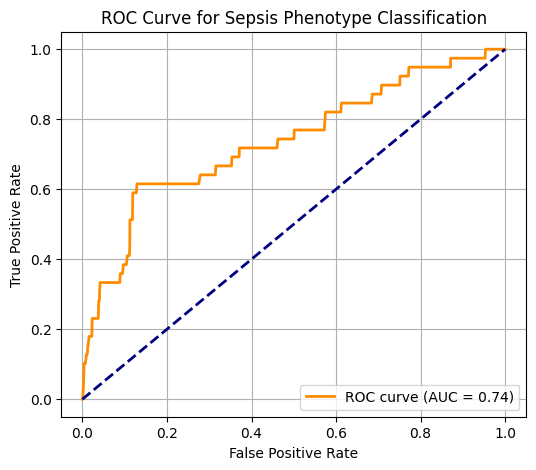

In [ ]:


y_prob = xgb_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Sepsis Phenotype Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

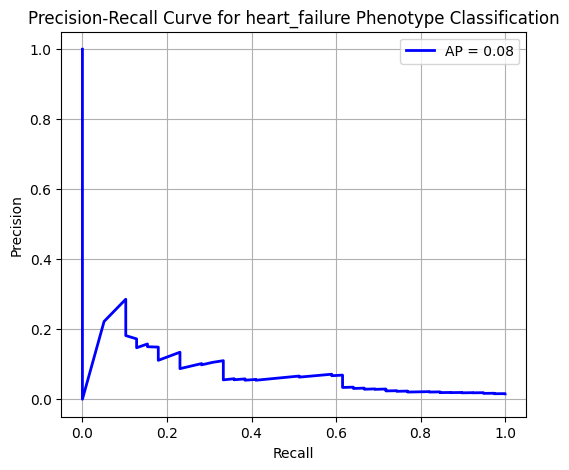

In [ ]:
# Precision-Recall Curve


precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='blue', lw=2, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for heart_failure Phenotype Classification')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

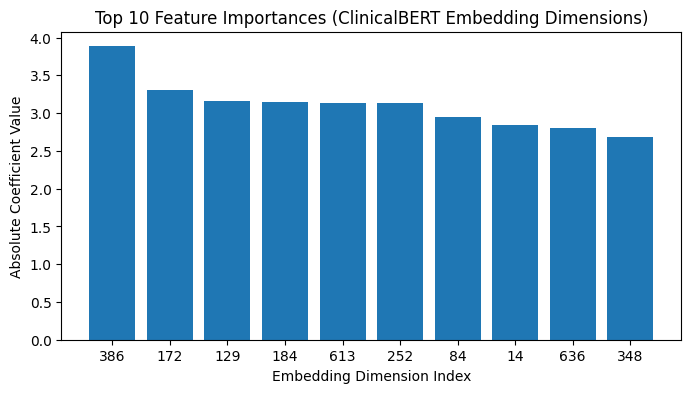

In [66]:
# Feature Importance (for linear models)
if hasattr(clf, "coef_"):
    importances = np.abs(clf.coef_[0])
    top_idx = np.argsort(importances)[-10:][::-1]
    plt.figure(figsize=(8, 4))
    plt.bar(range(10), importances[top_idx])
    plt.title("Top 10 Feature Importances (ClinicalBERT Embedding Dimensions)")
    plt.xlabel("Embedding Dimension Index")
    plt.ylabel("Absolute Coefficient Value")
    plt.xticks(range(10), top_idx)
    plt.show()